# Image Classification

Each section represents a stage along implementing an image classifier, from loading and inspecting the dataset to training a **pre-trained** Convolutional Neural Network architecture. The sections are to guide you but you do not have to follow that specific order.


**Note** Make sure the notebook is using GPU accelerataion in Edit -> Notebook settings, otherwise training and evaluation can be very slow.


## Task description
The task is to train an already pretrained Convolutional Neural Network architecture on a dataset. The datasets contain images as input and class labels as target, thus you have to solve a Supervised Machine Learning Classification problem.

The dataset shoud be divided into train, validation and test set, for which results should be presented for all.

You can either train the architecture you were given without changing its layers, or you can add more layers, if you believe it increases the accuracy. There is no expected percentage of accuracy, but **your accuracy should be better than random guessing and your loss has to decrease throughout the epochs**. We expect you to show visualisations (any of the following: matplotlib, seaborn, tensorboard, ...) of the accuracy and loss and use Early stopping while training your network.



## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [17]:
!pip3 install wget
!pip3 install tqdm
from tqdm import tqdm
from torch.utils.data import Subset, Dataset, DataLoader, random_split
import wget # download files
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 1. Dataset
Load the dataset you were given. Images should be stored in an X variable and your labels in a Y variable. Split your dataset into train, validation and test set and pre-process your data for training.

#### Loading the dataset
Show some images and labels of your dataset

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# This is all the dataset
# https://drive.google.com/file/d/1Xdzvv0LBCpeVReKhQoU4DFifFychNMvk/view?usp=sharing

# This is part of the caltech dataset
!wget https://raw.githubusercontent.com/peymanlee/Image-classification-with-CNN-on-the-Caltech-dataset/main/CaltechDataSet.zip --no-check-certificate
!unzip CaltechDataSet.zip -d data

--2023-07-02 15:52:59--  https://raw.githubusercontent.com/peymanlee/Image-classification-with-CNN-on-the-Caltech-dataset/main/CaltechDataSet.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6758474 (6.4M) [application/zip]
Saving to: ‘CaltechDataSet.zip’

CaltechDataSet.zip  100%[===================>]   6.45M  --.-KB/s    in 0.03s   

2023-07-02 15:53:00 (239 MB/s) - ‘CaltechDataSet.zip’ saved [6758474/6758474]

Archive:  CaltechDataSet.zip
  inflating: data/101_ObjectCategories/gramophone/image_0036.jpg  
  inflating: data/101_ObjectCategories/gramophone/image_0001.jpg  
  inflating: data/101_ObjectCategories/gramophone/image_0035.jpg  
  inflating: data/101_ObjectCategories/gramophone/image_0024.jpg  
  inflating: data/101_ObjectCategories/gramophone/i

In [5]:
# data_dir = '/content/drive/MyDrive/101_ObjectCategories'
data_dir = 'data/101_ObjectCategories'

normalization = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), normalization])
image_datasets = datasets.ImageFolder(os.path.join(data_dir, ""), transform)
class_names = image_datasets.classes

In [6]:
class_names

['bonsai', 'butterfly', 'car_side', 'gramophone', 'helicopter']

In [7]:
# Some constants
DEVICE = 'cuda'
Batch_size = 32
num_epochs = 10

#### Splitting the dataset

In [8]:
train_size = int(0.7 * len(image_datasets))
val_size = int(0.15 * len(image_datasets))
test_size = len(image_datasets) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(image_datasets, [train_size, val_size, test_size])


#### Pre-processing the dataset

In [9]:

train_dataloader = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=Batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=Batch_size, shuffle=True, num_workers=4)


In [10]:

image_datasets = {'train': train_dataset, 'val':val_dataset, 'tets': test_dataset}
dataloaders = {'train': train_dataloader, 'val':val_dataloader, 'test':test_dataloader}
dataset_sizes = {'train':train_size, 'val':val_size, 'test':test_size}

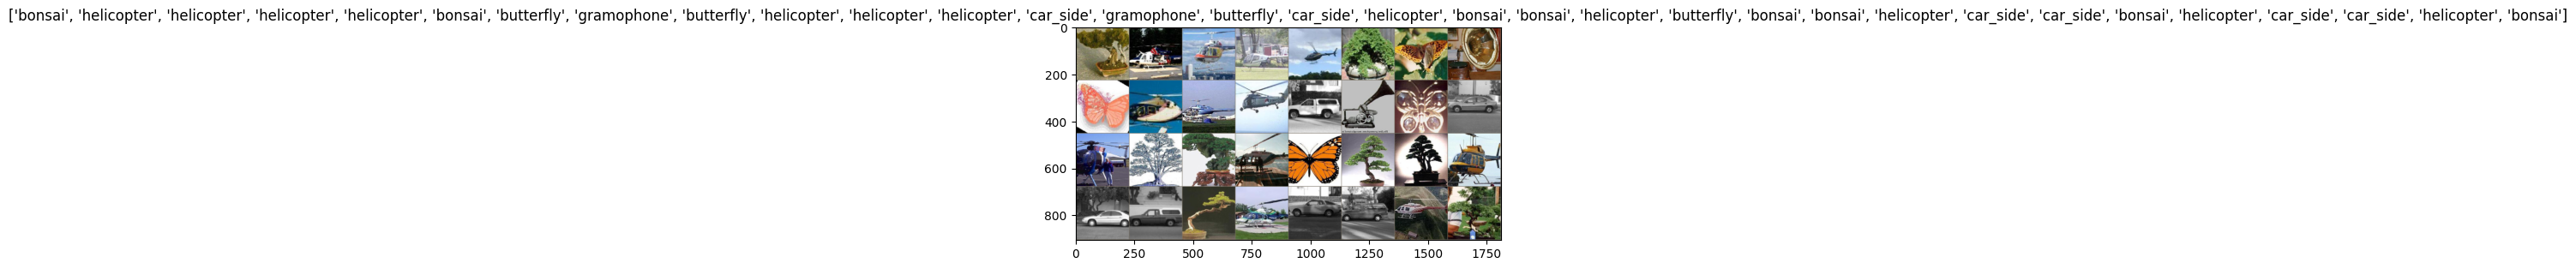

In [11]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 2. Convolutional Neural Network Architecture
Load the CNN architecture you were given using pretrained weights. Define the optimizer and loss function. Train your network and save it. Remember to use Early stopping and show results.

#### Load the architecture

In [12]:
mymodel = models.alexnet(pretrained=True)
mymodel

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:00<00:00, 312MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

#### Define your optimizer and loss function

In [13]:
num_classes = len(class_names)
mymodel.classifier[6] = nn.Linear(4096, num_classes)
criterion_val = nn.CrossEntropyLoss(reduction='sum')
parameters_to_optimize = mymodel.classifier.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=0.0001, momentum=0.9, weight_decay=5e-5)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

#### Train your network

In [14]:
val_acc_h = []
train_acc_h = []
val_loss_h = []
train_loss_h = []
for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0

    mymodel.train()

    for inputs, labels in train_dataloader:
        optimizer.zero_grad()

        outputs = mymodel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data)

    train_loss = train_loss / len(train_dataset)
    train_loss_h.append(train_loss)
    train_acc = train_correct.double() / len(train_dataset)
    train_acc_h.append(train_acc)

    # Evaluate the model on the validation set
    val_loss = 0.0
    val_correct = 0

    mymodel.eval()

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            outputs = mymodel(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data)

        val_loss = val_loss / len(val_dataset)
        val_loss_h.append(val_loss)
        val_acc = val_correct.double() / len(val_dataset)

    val_acc_h.append(val_acc)
    # Print the epoch results
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/10: Train Loss: 1.4325 | Train Acc: 0.3869 | Val Loss: 0.9141 | Val Acc: 0.7083
Epoch 2/10: Train Loss: 0.6907 | Train Acc: 0.7946 | Val Loss: 0.5041 | Val Acc: 0.9306
Epoch 3/10: Train Loss: 0.3645 | Train Acc: 0.9345 | Val Loss: 0.3497 | Val Acc: 0.9583
Epoch 4/10: Train Loss: 0.2360 | Train Acc: 0.9554 | Val Loss: 0.2864 | Val Acc: 0.9583
Epoch 5/10: Train Loss: 0.1835 | Train Acc: 0.9762 | Val Loss: 0.2514 | Val Acc: 0.9583
Epoch 6/10: Train Loss: 0.1427 | Train Acc: 0.9851 | Val Loss: 0.2307 | Val Acc: 0.9583
Epoch 7/10: Train Loss: 0.1128 | Train Acc: 0.9940 | Val Loss: 0.2179 | Val Acc: 0.9583
Epoch 8/10: Train Loss: 0.1032 | Train Acc: 0.9940 | Val Loss: 0.2096 | Val Acc: 0.9583
Epoch 9/10: Train Loss: 0.0990 | Train Acc: 0.9881 | Val Loss: 0.2025 | Val Acc: 0.9583
Epoch 10/10: Train Loss: 0.0819 | Train Acc: 0.9970 | Val Loss: 0.1979 | Val Acc: 0.9583


#### Show results (accuracy and loss) on training and validation sets

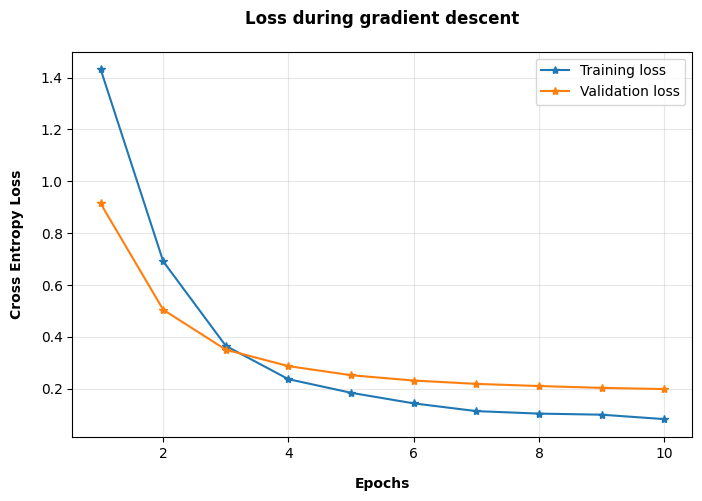

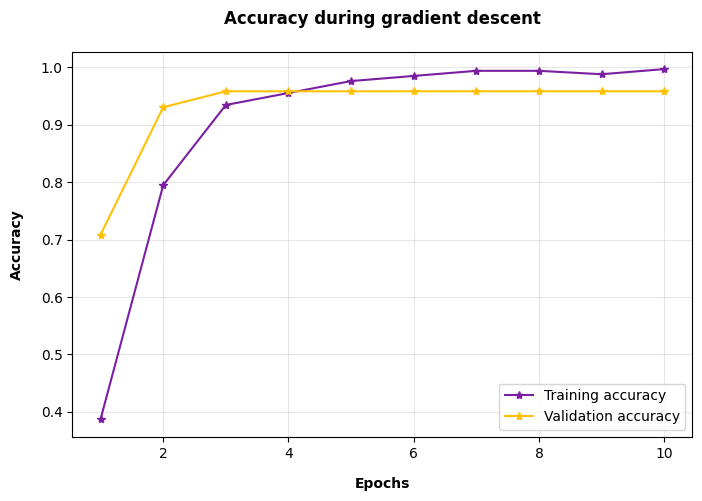

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

epochs = [i for i in range(1, num_epochs+1)]
ax.plot(epochs, train_loss_h, linestyle='-', marker='*', label='Training loss')
ax.plot(epochs, val_loss_h, linestyle='-', marker='*', label='Validation loss')

ax.set_xlabel('Epochs', labelpad=12, fontweight='bold')
ax.set_ylabel('Cross Entropy Loss', labelpad=12, rotation=90, fontweight='bold')

ax.set_title('Loss during gradient descent', pad=20, fontweight='bold')

ax.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot accuracies

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,5))

epochs = [i for i in range(1, num_epochs+1)]
ax.plot(epochs, train_acc_h, color='#7B1FA2', linestyle='-', marker='*', label='Training accuracy')
ax.plot(epochs, val_acc_h, color='#FFC107', linestyle='-', marker='*', label='Validation accuracy')

ax.set_xlabel('Epochs', labelpad=12, fontweight='bold')
ax.set_ylabel('Accuracy', labelpad=12, rotation=90, fontweight='bold')

ax.set_title('Accuracy during gradient descent', pad=20, fontweight='bold')

ax.legend()
plt.grid(alpha=0.3)
plt.show()

## 3. Conclusion (Evaluation)
Load your trained CNN and evaluate it on the test set. Show some predictions on the test set (3 is enough) by ploting the image and printing the prediction and ground truth.

How good are your results? Do you think the network is overfitted or underfitted? If yes, what do you think lead to that? If not, justify.

#### Evaluate your model

Test

In [18]:
mymodel = mymodel.to(DEVICE)
mymodel.train(False)

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)
  outputs = mymodel(images)
  _, preds = torch.max(outputs.data, 1)
  running_corrects += torch.sum(preds == labels.data).data.item()

accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 3/3 [00:09<00:00,  3.24s/it]

Test Accuracy: 0.9726027397260274


#### Show some predictions

In [19]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                fig = plt.figure(figsize=(10,10))
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

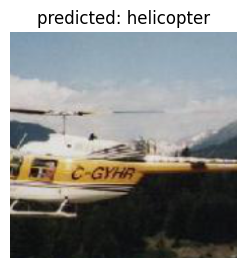

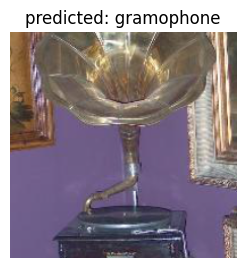

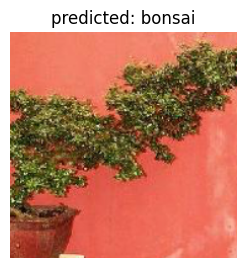

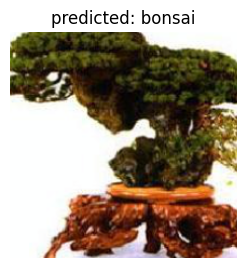

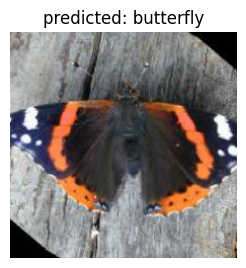

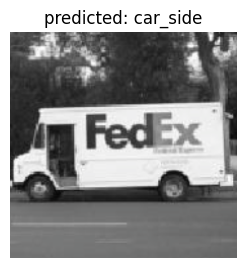

In [21]:
visualize_model(mymodel)

plt.ioff()
plt.show()